In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import copy


In [2]:
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Hao_PBMC_GSE164378.h5ad")
# adata = sc.read_h5ad("/home/jovyan/work/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad")
adata.shape

(161764, 33538)

In [4]:
# meta = pd.read_csv(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\GSE164378_sc.meta.data_3P.csv", index_col=0)
meta = pd.read_csv('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/GSE164378_sc.meta.data_3P.csv', index_col=0)
# meta = pd.read_csv(r"/home/jovyan/work/Research_datasets/PBMC_Hao/GSE164378_Hao/GSE164378_sc.meta.data_3P.csv", index_col=0)
adata.obs['time'] = meta['time']
adata.obs['lane'] = meta['lane']

In [5]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Phase,Batch,donor,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,time,lane
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,G1,Batch1,P2,7535,217,10823,2915,7,L1
L1_AAACCCAAGACATACA,CD4 T,CD4 TCM,CD4 TCM_1,G1,Batch1,P1,6013,209,5864,1617,7,L1
L1_AAACCCACAACTGGTT,CD8 T,CD8 Naive,CD8 Naive,S,Batch1,P4,6620,213,5067,1381,2,L1
L1_AAACCCACACGTACTA,NK,NK,NK_2,G1,Batch1,P3,3567,202,4786,1890,7,L1
L1_AAACCCACAGCATACT,CD8 T,CD8 Naive,CD8 Naive,G1,Batch1,P4,6402,215,6505,1621,7,L1


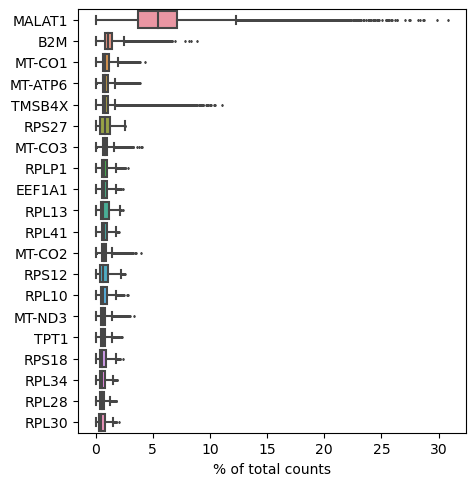

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

## Normalization

In [6]:
# Normalization
# each observation (cell) has a total count equal to the median of total counts for observations (cells)
sc.pp.normalize_total(adata, target_sum=None)
# log1p transformation
sc.pp.log1p(adata)

## HVG

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


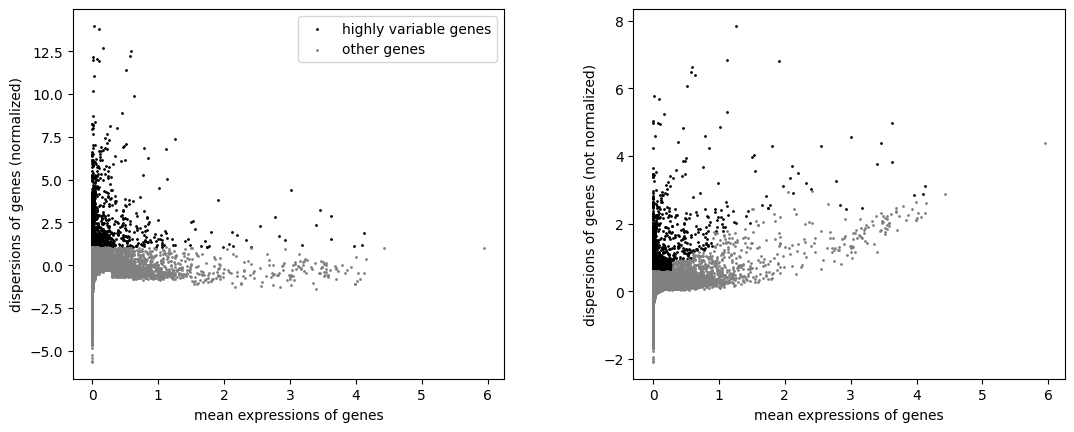

In [7]:
# HVG2000
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [8]:
adata.var.highly_variable.sum()

2000

In [9]:
adata.raw = adata

In [10]:
# filtering HVG2000
adata = adata[:, adata.var.highly_variable]
adata.shape

(161764, 2000)

In [11]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## UMAP before batch effect correction

In [12]:
sc.tl.pca(adata, svd_solver="arpack")

In [13]:
# neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


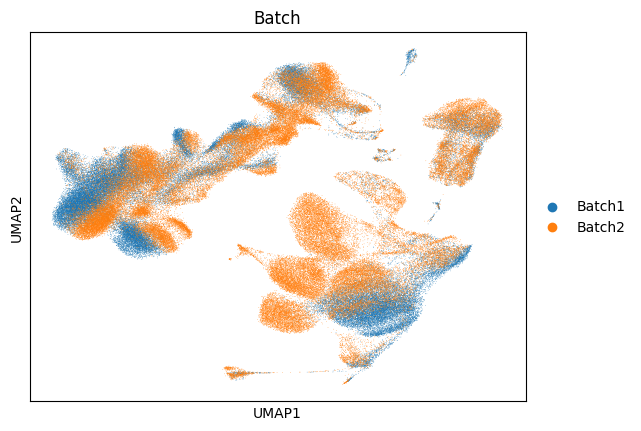

In [14]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='Batch')

## Batch effect correction with bbknn

In [15]:
import bbknn

bbknn.bbknn(adata, batch_key='Batch')

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


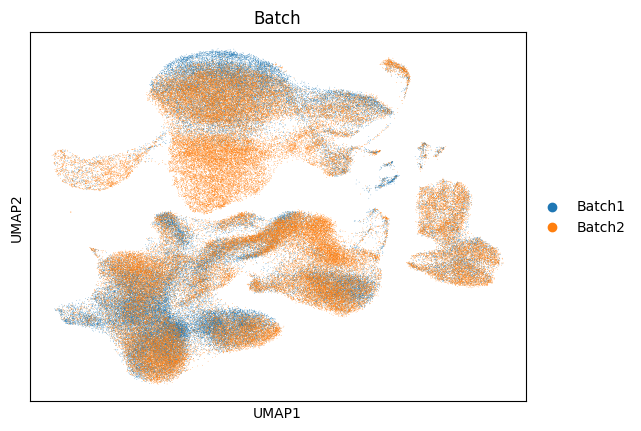

In [16]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='Batch')

## Leiden

In [17]:
sc.tl.leiden(adata, resolution=0.9)

In [18]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

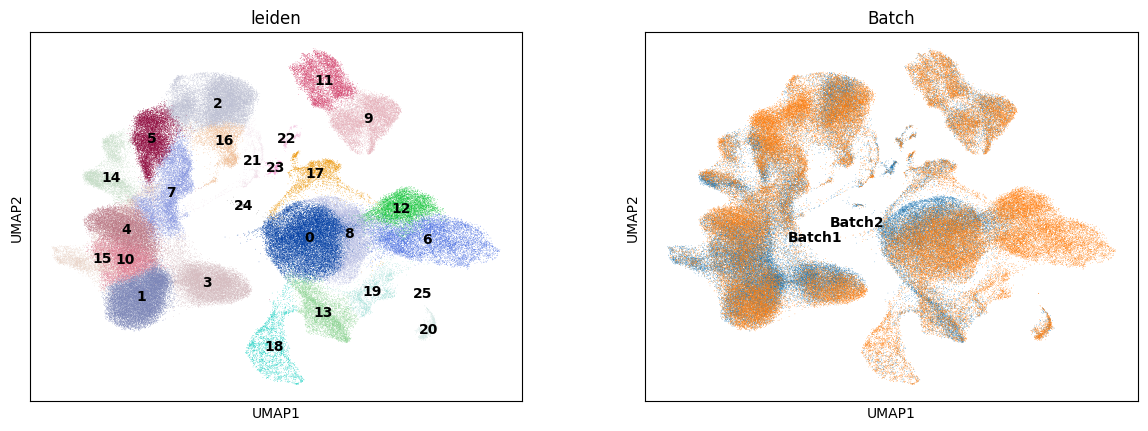

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

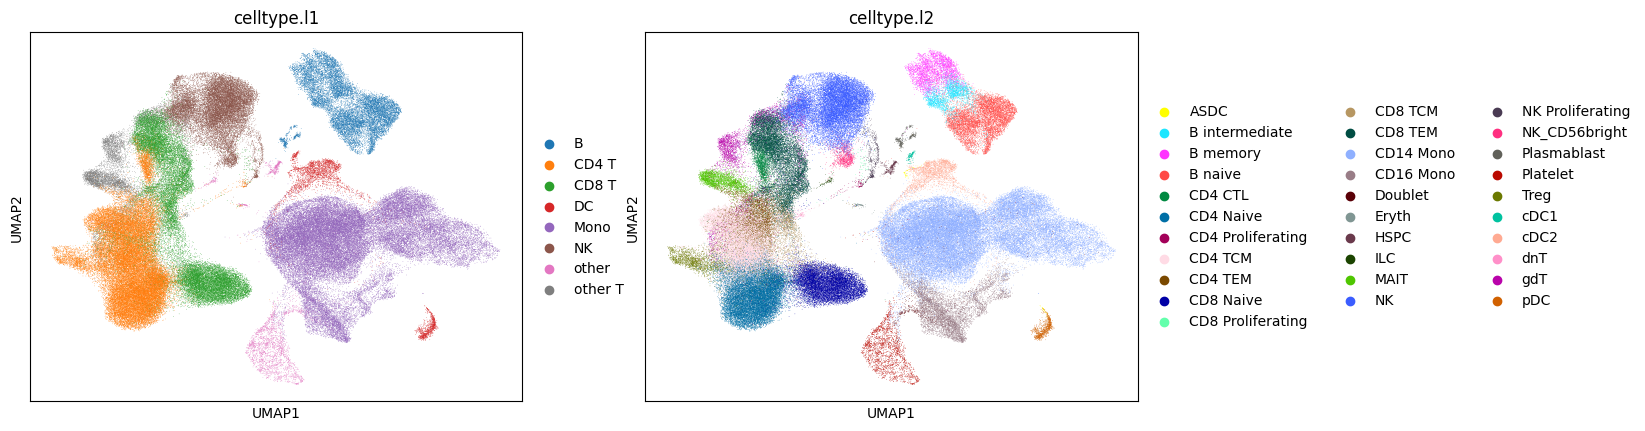

In [19]:
sc.pl.umap(adata, color=['leiden', 'Batch'], legend_loc="on data")
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2'], legend_loc="right margin")

In [20]:
adata.obs['leiden'].unique()

['0', '10', '3', '2', '7', ..., '23', '18', '19', '24', '25']
Length: 26
Categories (26, object): ['0', '1', '2', '3', ..., '22', '23', '24', '25']

In [26]:
adata.shape

(161764, 2000)

In [59]:
adata.obs['celltype.l1'].unique().tolist().sort()

In [60]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Phase,Batch,donor,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,time,lane,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,G1,Batch1,P2,7535,217,10823,2915,7,L1,0
L1_AAACCCAAGACATACA,CD4 T,CD4 TCM,CD4 TCM_1,G1,Batch1,P1,6013,209,5864,1617,7,L1,10
L1_AAACCCACAACTGGTT,CD8 T,CD8 Naive,CD8 Naive,S,Batch1,P4,6620,213,5067,1381,2,L1,3
L1_AAACCCACACGTACTA,NK,NK,NK_2,G1,Batch1,P3,3567,202,4786,1890,7,L1,2
L1_AAACCCACAGCATACT,CD8 T,CD8 Naive,CD8 Naive,G1,Batch1,P4,6402,215,6505,1621,7,L1,3


## Plot celltype cell numbers

In [ ]:
# Get cell counts for each cell type
l1_cell_counts = adata.obs['celltype.l1'].value_counts()  # in value order 
l2_cell_counts = adata.obs['celltype.l2'].value_counts()

# Get colors from sc.pl.umap() plot
l1_colors = adata.uns['celltype.l1_colors']  # in celltype alphabet order
l2_colors = adata.uns['celltype.l2_colors']
# map cell type names to colors
l1_cmap = dict(zip(l1_cell_counts.index.sort_values(), l1_colors))  # in alphabet order
l2_cmap = dict(zip(l2_cell_counts.index.sort_values(), l2_colors))

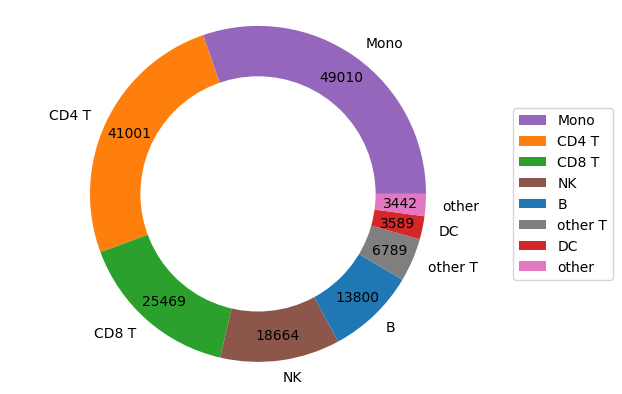

In [92]:
# Define a function to format the autopct parameter
def absolute_value(val):
    a = round(val/100.*l1_cell_counts.sum())
    return f"{a:d}"

# Plot pie chart with actual cell counts
color_list = [l1_cmap[celltype] for celltype in l1_cell_counts.index]
plt.pie(l1_cell_counts, labels=l1_cell_counts.index, colors=color_list, autopct=absolute_value, pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Move legend to the right side of the chart
plt.legend(l1_cell_counts.index.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

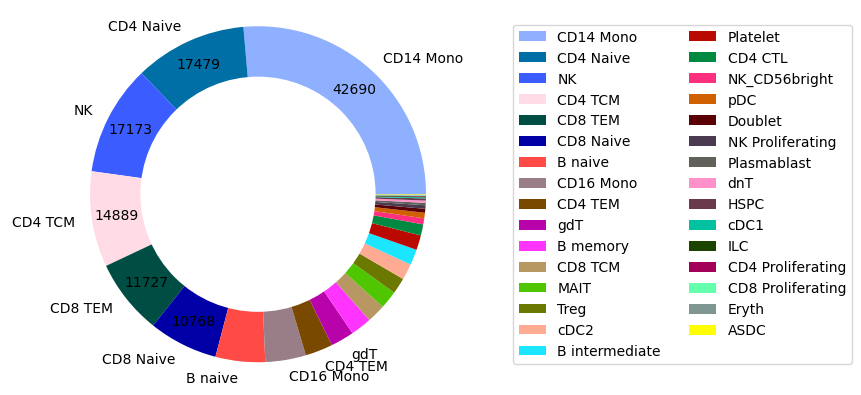

In [94]:
import matplotlib.pyplot as plt

# Get the top 6 cell types
top_6_types = l2_cell_counts.index[:6]

# Define a custom autopct function
def custom_autopct(pct):
    total = sum(l2_cell_counts)
    count = int(round(pct*total/100.0))
    return f"{count}" if l2_cell_counts[l2_cell_counts == count].index[0] in top_6_types else ""

top_10_labels = l2_cell_counts.index.tolist()[:10] + [' ']*21
# Plot pie chart for all 31 cell types
color_list = [l2_cmap[celltype] for celltype in l2_cell_counts.index]
plt.pie(l2_cell_counts, colors=color_list, labels=top_10_labels, autopct=custom_autopct, pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Move legend to the right side of the chart
plt.legend(l2_cell_counts.index.tolist(), loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

# Show the plot
plt.show()


In [99]:
# save colormap as json
import json
colormap = {'l1': l1_cmap, 'l2': l2_cmap}
with open('Hao_colormap.json', 'w') as f:
    json.dump(colormap, f)